## Decitabine treatment RNA-Seq 5 other AML cell lines 
Here, I'll run basic DESeq2 analysis 

## Pre-processing 

I'm mapping `hg38/gencode.v34` to the `fastq` files using salmon. 

Raw samples:

In [3]:
ls ../other-fastq/*fastq.gz

../other-fastq/kg1_t_1.fastq.gz      ../other-fastq/ociaml2_u_1.fastq.gz
../other-fastq/kg1_t_2.fastq.gz      ../other-fastq/ociaml2_u_2.fastq.gz
../other-fastq/kg1_t_3.fastq.gz      ../other-fastq/ociaml2_u_3.fastq.gz
../other-fastq/kg1_u_1.fastq.gz      ../other-fastq/ociaml3_t_1.fastq.gz
../other-fastq/kg1_u_2.fastq.gz      ../other-fastq/ociaml3_t_2.fastq.gz
../other-fastq/kg1_u_3.fastq.gz      ../other-fastq/ociaml3_t_3.fastq.gz
../other-fastq/molm14_t_1.fastq.gz   ../other-fastq/ociaml3_u_1.fastq.gz
../other-fastq/molm14_t_2.fastq.gz   ../other-fastq/ociaml3_u_2.fastq.gz
../other-fastq/molm14_t_3.fastq.gz   ../other-fastq/ociaml3_u_3.fastq.gz
../other-fastq/molm14_u_1.fastq.gz   ../other-fastq/thp1_t_1.fastq.gz
../other-fastq/molm14_u_2.fastq.gz   ../other-fastq/thp1_t_2.fastq.gz
../other-fastq/molm14_u_3.fastq.gz   ../other-fastq/thp1_t_3.fastq.gz
../other-fastq/ociaml2_t_1.fastq.gz  ../other-fastq/thp1_u_1.fastq.gz
../other-fastq/ociaml2_t_2.fastq.gz  ../other-fastq/thp1_u_2.fa

In [2]:
%reload_ext rpy2.ipython

In [4]:
%%R 
library (GenomicFeatures)
library (tximport)
library (tidyverse)
library (ggplot2)
library (ggrepel)
library (DESeq2)
library (patchwork)
library (BiocParallel)
register(MulticoreParam(18))

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}

Load annotations

In [5]:
%%R
GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK

R[write to console]: 'select()' returned 1:1 mapping between keys and columns



import salmon quants:

In [6]:
%%R
files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)

txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=T)

txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

R[write to console]: reading in files with read_tsv

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 5 
R[write to console]: 6 
R[write to console]: 7 
R[write to console]: 8 
R[write to console]: 9 
R[write to console]: 10 
R[write to console]: 11 
R[write to console]: 12 
R[write to console]: 13 
R[write to console]: 14 
R[write to console]: 15 
R[write to console]: 16 
R[write to console]: 17 
R[write to console]: 18 
R[write to console]: 19 
R[write to console]: 20 
R[write to console]: 21 
R[write to console]: 22 
R[write to console]: 23 
R[write to console]: 24 
R[write to console]: 25 
R[write to console]: 26 
R[write to console]: 27 
R[write to console]: 28 
R[write to console]: 29 
R[write to console]: 30 
R[write to console]: 

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



Define the sample sheet

In [7]:
%%R 
# meta 
lines   <- lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist 
treats  <- rep(c(rep('treated',3), rep('DMSO',3)),5)
reps    <- rep(c('rep1','rep2','rep3'),5)

colData <- data.frame(
    line=lines, 
    cond=treats, 
    sample_id=paste(lines, treats, reps, sep='_'), 
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

               line    cond            sample_id
kg1_t_1         kg1 treated     kg1_treated_rep1
kg1_t_2         kg1 treated     kg1_treated_rep2
kg1_t_3         kg1 treated     kg1_treated_rep3
kg1_u_1         kg1    DMSO        kg1_DMSO_rep1
kg1_u_2         kg1    DMSO        kg1_DMSO_rep2
kg1_u_3         kg1    DMSO        kg1_DMSO_rep3
molm14_t_1   molm14 treated  molm14_treated_rep1
molm14_t_2   molm14 treated  molm14_treated_rep2
molm14_t_3   molm14 treated  molm14_treated_rep3
molm14_u_1   molm14    DMSO     molm14_DMSO_rep1
molm14_u_2   molm14    DMSO     molm14_DMSO_rep2
molm14_u_3   molm14    DMSO     molm14_DMSO_rep3
ociaml2_t_1 ociaml2 treated ociaml2_treated_rep1
ociaml2_t_2 ociaml2 treated ociaml2_treated_rep2
ociaml2_t_3 ociaml2 treated ociaml2_treated_rep3
ociaml2_u_1 ociaml2    DMSO    ociaml2_DMSO_rep1
ociaml2_u_2 ociaml2    DMSO    ociaml2_DMSO_rep2
ociaml2_u_3 ociaml2    DMSO    ociaml2_DMSO_rep3
ociaml3_t_1 ociaml3 treated ociaml3_treated_rep1
ociaml3_t_2 ociaml3 

### Functions:

In [79]:
%%R

# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    # at least 3 samples with a count of 10 or higher
    # keep <- rowSums(counts(dds) >= 10) >= 3

    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(size = 2,  color=group), alpha = 4/10) +
            geom_text_repel(aes(label = row.names(colData)),size = 3.5) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position=leg)
    return (pca)
}

plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,],
                aes(label = gene_name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}

## PCA and Differential Expression Analysis 

In [9]:
%%R 
dds0 <- DESeqDataSetFromTximport(txi.gene, colData, ~ line + cond)
dds0$cond = relevel(dds0$cond, ref='DMSO')
nrow(dds0)

R[write to console]: using counts and average transcript lengths from tximport



[1] 60240


In [10]:
%%R 
dds1 <- DESeq(dds0, parallel=TRUE)
# results 
vsd1 <- varianceStabilizingTransformation(dds1)

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates: 18 workers

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates, fitting model and testing: 18 workers



In [72]:
%%R 
# save normazlied counts 
dds0 <- estimateSizeFactors(dds0)
ncu <- counts(dds0, normalized=TRUE) 
colnames(ncu) <- colData$sample_id
ncu = ncu %>% 
    data.frame %>% add_column(gene_name=gene2name[rownames(dds0),]) %>% rownames_to_column('gene_id') %>% 
    dplyr::select('gene_id','gene_name',colData$sample_id)

write_Result(ncu,'other_exp_deseq2_norm.txt',col=TRUE,row=FALSE)

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size



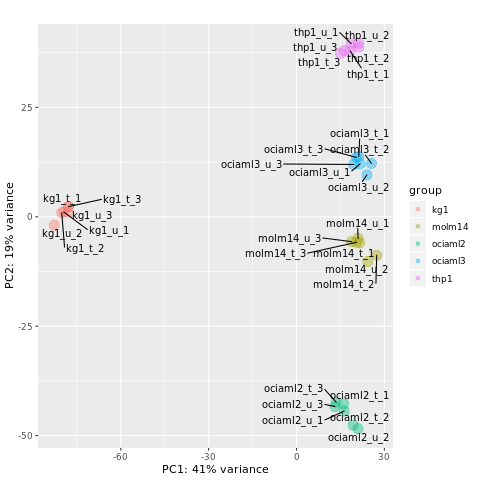

In [12]:
%%R 
pca = plot_PCA(vsd1, colData, gr=c('line'), leg='right')
pca

In [13]:
%%R
plot_Save(pca,'PCA_all_cell_lines')

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



In [14]:
# %%R
# par(mar=c(15,5,1,1))
# boxplot(log10(assays(dds1)[["cooks"]]), range=0, las=2)

Create seprate `dds` object for each cell line to do stable PCAs. 

In [31]:
%%R 
dds1 <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

DDS0 = list()
DDS1 = list()
VSD = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData$line) ){
    k = colData$line == l
    # dds object for each cell line 
    DDS0[[l]] <- dds1[,c(k)] # subset samples from dds object https://www.biostars.org/p/442188/
    
    # for Differential Expression
    DDS0[[l]] = DESeq(DDS0[[l]]) #, parallel=TRUE)
        
    # for PCA 
    DDS1[[l]] <- filter_low_counts(DDS0[[l]])
    print (l)
    VSD[[l]] <- varianceStabilizingTransformation(DDS1[[l]])

}

R[write to console]: using counts and average transcript lengths from tximport

R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "60240 genes filtered to -> 11073 genes!"
[1] "kg1"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "60240 genes filtered to -> 9886 genes!"
[1] "molm14"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "60240 genes filtered to -> 10334 genes!"
[1] "ociaml2"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "60240 genes filtered to -> 10812 genes!"
[1] "ociaml3"


R[write to console]: estimating size factors

R[write to console]: using 'avgTxLength' from assays(dds), correcting for library size

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "60240 genes filtered to -> 11297 genes!"
[1] "thp1"


In [16]:
%%R 
# for loop fails!!! 
kg1 <- plot_PCA(
    VSD[["kg1"]], 
    colData[colData$line == "kg1",], 
    title = 'cell line: kg1'
) 

molm14 <- plot_PCA(
    VSD[["molm14"]], 
    colData[colData$line == "molm14",], 
    title = 'cell line: molm14'
)

thp1 <- plot_PCA(
    VSD[["thp1"]][,c(rownames(colData[colData$line == "thp1",])!='thp1_u_2')], 
    colData[colData$line == "thp1" & rownames(colData)!='thp1_u_2',], 
    title = 'cell line: thp1'
)

ociaml2 <- plot_PCA(
    VSD[["ociaml2"]][,c(rownames(colData[colData$line == "ociaml2",])!='ociaml2_u_2')],
    colData[colData$line == "ociaml2" & rownames(colData)!='ociaml2_u_2',], 
    title = 'cell line: ociaml2'
)

ociaml3 <- plot_PCA(
    VSD[["ociaml3"]], 
    colData[colData$line == "ociaml3",], 
    title = 'cell line: ociaml3'
)

In [20]:
%%R 
p1 = kg1 / molm14 / thp1
p2 = ociaml2 / ociaml3

#start pdf
pdf('plots/PCA_split_cell_lines.pdf')
print (p1)
print (p2)
#end pdf
dev.off()

png 
  2 


Get results:

In [76]:
%%R    
RES = list()
for (line in names(DDS0) ){ 

    # get results 
    res = results(DDS0[[line]], parallel=TRUE)   %>% data.frame %>% 
    rownames_to_column('gene_id') %>%
    add_column(gene_name=gene2name[rownames(DDS0[[line]]),]) %>%
    add_column(ensembl=rownames(DDS0[[line]]) %>% substr(0, 15))
    
    write_Result(res %>% dplyr::select('gene_id','gene_name','baseMean','log2FoldChange','lfcSE','stat','pvalue','padj'),
                 paste(line,'_delta_exp_table.txt', sep=''),col=TRUE)
    
    RES[[line]] = res 

}

Draw volcano plots:

In [80]:
%%R 
for (line in  names(RES)){
    pdf(paste0('plots/',line,'_Volcano_plots.pdf', sep='') )
    print (plot_Volcano(RES[[line]], title = paste('cell line:', line) ) )
    dev.off()
}

## Heatmap Clustering 

In [20]:
%%R 
sig_genes = RES[[1]][drop_na(
    data.frame(sig=
#                abs(RES[[1]]$log2FoldChange) > 2 | abs(RES[[2]]$log2FoldChange) > 2 |
#                abs(RES[[3]]$log2FoldChange) > 2 | abs(RES[[4]]$log2FoldChange) > 2 |
#                abs(RES[[5]]$log2FoldChange) > 2 | 
               RES[[1]]$pvalue < 0.001 | RES[[2]]$pvalue < 0.001 |
               RES[[3]]$pvalue < 0.001 | RES[[4]]$pvalue < 0.001 | 
               RES[[5]]$pvalue < 0.001 ))$sig, ] %>% rownames

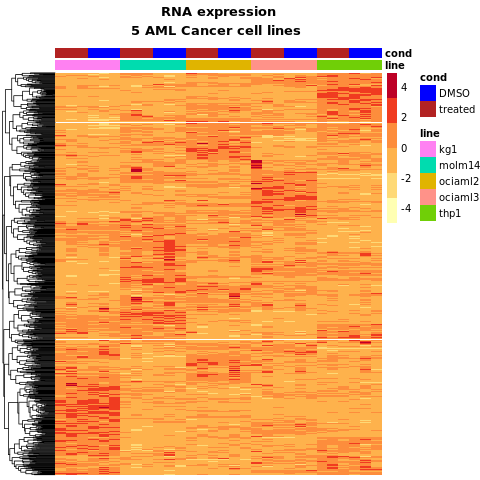

In [24]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[sig_genes, ] %>% dplyr::distinct(name,.keep_all= TRUE) %>% remove_rownames %>% column_to_rownames('name') 
sig_norm_counts <- sig_norm_counts[rowSums(sig_norm_counts > 10) == ncol(sig_norm_counts),]

# # Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

ann_colors = list(
    cond = c('DMSO'="blue", 'treated'="firebrick")# ,
#     line = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
)

# Plot heatmap
h = pheatmap(sig_norm_counts, 
         color = heat_colors, 
         cluster_cols = F, 
#          cluster_rows = T, 
         show_colnames = F,
         show_rownames = F,
         main = 'RNA expression\n5 AML Cancer cell lines ',
         annotation = select(colData, line, cond), 
         scale = 'row',
         angle_col= 45,
#          annotation_legend=F,
         annotation_colors = ann_colors
)


In [25]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h$gtable)
dev.off()

png 
  2 


In [20]:
%%R 
sig_genes = RES[[1]][drop_na(
    data.frame(sig=
#                abs(RES[[1]]$log2FoldChange) > 2 | abs(RES[[2]]$log2FoldChange) > 2 |
#                abs(RES[[3]]$log2FoldChange) > 2 | abs(RES[[4]]$log2FoldChange) > 2 |
#                abs(RES[[5]]$log2FoldChange) > 2 | 
               RES[[1]]$pvalue < 0.001 | RES[[2]]$pvalue < 0.001 |
               RES[[3]]$pvalue < 0.001 | RES[[4]]$pvalue < 0.001 | 
               RES[[5]]$pvalue < 0.001 ))$sig, ] %>% rownames

## Enrichment analysis

Prepare results for running iPAGE:

In [26]:
%%R 
for (l in unique(colData$line) ){
    print (l)
    
    write_Result(RES[[l]] [,c('ensembl','log2FoldChange')] %>% 
        remove_rownames, paste(l,'_delta_exp.txt', sep ='') )
}

[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


In [29]:
%%bash 
ipage=~/Workflows/my_scripts/ipage_human_ensembl.sh
nohup ls *_delta_exp.txt | parallel -j18 -k bash $ipage {} &> ipage.out &

In [64]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0             DESeq2_1.20.0              
 [3] SummarizedExperiment_1.10.1 DelayedArray_0.6.6         
 [5] BiocParallel_1.14.2         matrixStats_0.55.0         
 [7] ggrepel_0.8.1               forcats_0.4.0              
 [9] stringr_1.4.0    